How to calculate:
https://www.binance.com/en/support/faq/360033525031

In [99]:
import pandas as pd
import ast
import numpy as np
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
load = 'eth'
df = pd.read_csv(f'data/orderbook_{load}_usdt.csv', parse_dates=['date'])
df['asks'] =  df['asks'].map(lambda d : ast.literal_eval(d))
df['bids'] =  df['bids'].map(lambda d : ast.literal_eval(d))

In [3]:
backup = df

In [4]:
#https://www.binance.com/en/futures/trading-rules/perpetual

specs = { #initial margin , maintenance margin rate
  'eth': (np.round(100000/100/100000,4), 0.005),
  'btc': (np.round(50000/125/50000,4), 0.004),
  'doge': (np.round(50000/50/50000,4), 0.01),
  'bnb': (np.round(10000/75/10000,4), 0.0065),
  'ada': (np.round(10000/75/10000,4), 0.0065),
}
specs

{'eth': (0.01, 0.005),
 'btc': (0.008, 0.004),
 'doge': (0.02, 0.01),
 'bnb': (0.0133, 0.0065),
 'ada': (0.0133, 0.0065)}

In [14]:
interest_index = 0.0001
imn = 200/specs['eth'][0] #(impact margin notional = 200 usdt / initial margin rate at maximum leverage level); 10% for doge

df['impact_ask'] = 0.0
df['impact_bid'] = 0.0


In [17]:
for i in range(0, len(df)):
    df['impact_ask'][i], df_temp = calc_impact_ask(imn, i)
    df['impact_bid'][i], df_temp = calc_impact_bid(imn, i)
    


In [87]:
df['premium_index'] = 0.0
random.seed(42)

#mid price is technically not correct: https://www.binance.com/en/futures/funding-history/3

def calc_premium_index(i):
    return (max(0, df['impact_bid'][i] - df['mid_price'][i] + random.uniform(-50, 50)) - max(0, df['mid_price'][i] - df['impact_ask'][i] + random.uniform(-50, 50))) / df['mid_price'][i]

df['premium_index'] = df['premium_index'].apply(calc_premium_index)

In [88]:
weights = np.arange(1,2*60*8+1,1) #weighted moving average for 8hours
df['wma_premium_index'] = df['premium_index'].rolling(2*60*8).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
df['wma_premium_index'] = df['wma_premium_index'].fillna(0)

In [95]:
df['funding_rate'] = df['wma_premium_index'] + interest_index
#clamp funding rate
df['funding_rate'][(df['wma_premium_index'] > -.0004) & (df['wma_premium_index'] < 0.0006)] = interest_index

#clamp funding rate to min and max
mmr = 0.005
floor = -0.75 * mmr
cap = 0.75 * mmr

df['funding_rate'] = [max(floor, min(i, cap))  for i in df['funding_rate']]

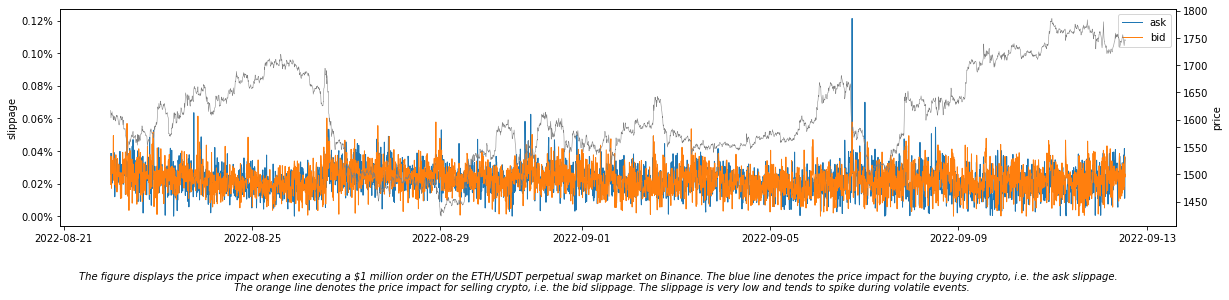

In [133]:
#take a look at the funding rate over time

fig, ax = plt.subplots(figsize =(20,4))

granularity = 2*10

ax.plot(df['date'].iloc[0::granularity], df['ask_slippage'].iloc[0::granularity], linewidth=1)
ax.plot(df['date'].iloc[0::granularity], df['bid_slippage'].iloc[0::granularity], linewidth=1)

secax = ax.twinx()
secax.plot(df['date'].iloc[0::granularity], df['mid_price'].iloc[0::granularity], color='grey', linewidth=.5)
secax.set_ylabel('price')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax.set_ylabel('slippage')

ax.legend(['ask','bid'])


txt = 'The figure displays the price impact when executing a $1 million order on the ETH/USDT perpetual swap market on Binance. The blue line denotes the price impact for the buying crypto, i.e. the ask slippage. \n The orange line denotes the price impact for selling crypto, i.e. the bid slippage. The slippage is very low and tends to spike during volatile events.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.savefig('figures/figure_x_SlippageAndPrice.png')

plt.show()

In [6]:
def calc_impact_bid(imn, i):
    df_temp = pd.DataFrame.from_dict(df['bids'][i], dtype='float')
    df_temp.sort_values(by='price', ascending=False, ignore_index=True, inplace=True)
    df_temp['cum_base_quantity'] = df_temp['amount'].cumsum()
    df_temp['quote_notional'] = df_temp['amount'] * df_temp['price']
    df_temp['cum_quote_notional'] = df_temp['quote_notional'].cumsum()
    
    df_temp['cum_quote_notional'].iloc[-1] += imn #hacky way of ensuring, that the last level is sufficient to cover imn
    
    idx = df_temp[df_temp['cum_quote_notional'] > imn].index[0] #determine which level is sufficient for imn
    if idx == 0:
        impact_bid = df_temp['price'][idx]
    else:
        impact_bid = imn / ((imn - df_temp['cum_quote_notional'][idx-1])/df_temp['price'][idx] + df_temp['cum_base_quantity'][idx-1])
    
    return impact_bid, df_temp

In [7]:
def calc_impact_ask(imn, i):
    df_temp = pd.DataFrame.from_dict(df['asks'][i], dtype='float')
    df_temp.sort_values(by='price', ascending=True, ignore_index=True, inplace=True)
    df_temp['cum_base_quantity'] = df_temp['amount'].cumsum()
    df_temp['quote_notional'] = df_temp['amount'] * df_temp['price']
    df_temp['cum_quote_notional'] = df_temp['quote_notional'].cumsum()
    
    df_temp['cum_quote_notional'].iloc[-1] += imn

    idx = df_temp[df_temp['cum_quote_notional'] > imn].index[0] #determine which level is sufficient for imn
    if idx == 0:
        impact_ask = df_temp['price'][idx]
    else:
        impact_ask = imn / ((imn - df_temp['cum_quote_notional'][idx-1])/df_temp['price'][idx] + df_temp['cum_base_quantity'][idx-1])
    
    return impact_ask, df_temp